### Script to plot maps using TC-tracked mask

In [20]:
from netCDF4 import Dataset
import numpy as np
import matplotlib
from matplotlib import ticker, cm, colors
# , markers
import matplotlib.pyplot as plt
import sys
import cartopy
import subprocess
from mask_tc_track import *
from azim_wind_latlon import *
from thermo_functions import *

#### Main Settings

In [21]:
istrat=-1 #2

# #### Time selection

nd = 2 # ndays
nt = nd*24
# nt = 2

# This has been tested for corresponding time steps:
#   t0=37,1 are the first divergent time steps in CTL,NCRF
#   t0=25,1 are the first divergent time steps in NCRF,CRFON
# t0=36
t0=0
t1 = t0+nt

# Pressure level to plot
pres_plot = 600

# #### Directories

storm='haiyan'
# storm='maria'

# main = "/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/wrfenkf/"
main = "/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/tc_ens/"
figdir = "/home/jamesrup/figures/tc/ens/"+storm+'/'

# memb='memb_01'
memb='memb_04'
test='ctl'

datdir2 = 'post/d02/'
# datdir2 = 'post/d02/v2/'
datdir = main+storm+'/'+memb+'/'+test+'/'+datdir2
# datdir+='v2/'

# TC tracking
ptrack='600' # tracking pressure level
var_track = 'rvor' # variable
rmax = 8 # radius (km) limit to keep unmasked

track_file = datdir+'../../track_'+var_track+'_'+ptrack+'hPa.nc'
# track_file = datdir+'../../../track_'+var_track+'_'+ptrack+'hPa.nc'

In [22]:
# TC Track
ncfile = Dataset(track_file)
clon = ncfile.variables['clon'][:] # deg
clat = ncfile.variables['clat'][:] # deg
ncfile.close()

In [23]:
##### Get dimensions
process = subprocess.Popen(['ls '+datdir+'../../wrfout_d02_*'],shell=True,
    stdout=subprocess.PIPE,universal_newlines=True)
output = process.stdout.readline()
wrffil = output.strip() #[3]
varfil_main = Dataset(wrffil)
lat = varfil_main.variables['XLAT'][:][0] # deg
lon = varfil_main.variables['XLONG'][:][0] # deg
lat1d = lat[:,0]
lon1d = lon[0,:]
nx1 = lat1d.size
nx2 = lon1d.size
varfil_main.close()

varfil_main = Dataset(datdir+'T.nc')
pres = varfil_main.variables['pres'][:] # hPa
nz = pres.size
varfil_main.close()

ikread = np.where(pres == pres_plot)[0][0]

In [24]:
def var_read_3d(datdir,varname,t0,t1,ik):
    varfil_main = Dataset(datdir+varname+'.nc')
    var = varfil_main.variables[varname][t0:t1,ik,:,:]
    var = var[:,np.newaxis,:,:]
    varfil_main.close()
    return var
def var_read_2d(datdir,varname,t0,t1):
    varfil_main = Dataset(datdir+varname+'.nc')
    var = varfil_main.variables[varname][t0:t1,:,:,:]
    varfil_main.close()
    return var

#### Read variables

In [25]:
# Read winds
varname = 'U10'
u = var_read_2d(datdir,varname,t0,t1)
varname = 'V10'
v = var_read_2d(datdir,varname,t0,t1)
# varname = 'U'
# u = var_read_3d(datdir,varname,t0,t1,ikread) # m/s
# varname = 'V'
# v = var_read_3d(datdir,varname,t0,t1,ikread)

# MSLP
# varname = 'SLP'
# mslp = var_read_2d(datdir,varname,t0,t1) # hPa

# Height
# varname = 'Z'
# hght = var_read_3d(datdir,varname,t0,t1,ikread)
# varfil_main = Dataset(datdir+'ZB.nc')
# hghtb = varfil_main.variables['ZB'][:,ikread,:,:] # m
# varfil_main.close()
# hght += hghtb[np.newaxis,:,:,:]

varname = 'AVOR'
# avor = var_read_3d(datdir,varname,t0,t1,ikread)

varname = 'rainrate'
rain = var_read_2d(datdir,varname,t0,t1) # mm/hr

# varname = 'LWUPT'
# olr = var_read_2d(datdir,varname,t0,t1) # W/m2

varfil_main = Dataset(datdir+'LWacre.nc')
lwacre = varfil_main.variables['LWUPB'][t0:t1,:,:,:] # W/m2
varfil_main.close()

# varname = 'QVAPOR'
# qv = var_read_3d(datdir,varname,t0,t1,ikread) # kg/kg
# varname = 'T'
# tmpk = var_read_3d(datdir,varname,t0,t1,ikread) # K
# var = relh(qv,pres[np.newaxis,ikread,np.newaxis,np.newaxis]*1e2,tmpk,ice=1) # %

In [26]:
# # For MSE variance terms

# lw_t = var_read_2d(datdir,'LWUPT',t0,t1) - var_read_2d(datdir,'LWDNT',t0,t1) # W/m2
# lw_b = var_read_2d(datdir,'LWUPB',t0,t1) - var_read_2d(datdir,'LWDNB',t0,t1) # W/m2
# lw_net = lw_b - lw_t

# lw_tc = var_read_2d(datdir,'LWUPTC',t0,t1) - var_read_2d(datdir,'LWDNTC',t0,t1) # W/m2
# lw_bc = var_read_2d(datdir,'LWUPBC',t0,t1) - var_read_2d(datdir,'LWDNBC',t0,t1) # W/m2 = J/m2/s
# lw_netc = lw_bc - lw_tc
# acre = lw_net - lw_netc

# lw_netc=np.squeeze(lw_netc)
# lw_net=np.squeeze(lw_net)
# acre=np.squeeze(acre)

# varfil_main = Dataset(datdir+'mse.nc')
# mse = varfil_main.variables['mse_int'][t0:t1,:,:] # J/m2
# varfil_main.close()

In [27]:
# # MSE variance term

# # Remove means
# mse_mean = np.mean(mse, axis=(1,2))
# msep = mse - mse_mean[:,np.newaxis,np.newaxis]
# lwmean = np.mean(lw_net, axis=(1,2))
# lwp = lw_net - lwmean[:,np.newaxis,np.newaxis]
# lwmeanc = np.mean(lw_netc, axis=(1,2))
# lwpc = lw_netc - lwmeanc[:,np.newaxis,np.newaxis]

# # Calculate covariance
# lwmse = msep*lwp # J/m2 * J/m2/s = (J/m2)^2 / s
# msevar = np.var(mse, axis=(1,2)) # (J/m2)^2
# lwmse /= msevar[:,np.newaxis,np.newaxis] # units = /s
# lwmse *= 3600*24 # s/day * /s = /day

# lwmsec = msep*lwpc # J/m2 * J/m2/s = (J/m2)^2 / s
# lwmsec /= msevar[:,np.newaxis,np.newaxis] # units = /s
# lwmsec *= 3600*24 # s/day * /s = /day

In [28]:
# Function to account for crossing of the Intl Date Line
def dateline_lon_shift(lon_in, reverse):
    if reverse == 0:
        lon_offset = np.zeros(lon_in.shape)
        lon_offset[np.where(lon_in < 0)] += 360
    else:
        lon_offset = np.zeros(lon_in.shape)
        lon_offset[np.where(lon_in > 180)] -= 360
    # return lon_in + lon_offset
    return lon_offset

In [29]:
track_file

'/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/tc_ens/haiyan/memb_04/ctl/post/d02/../../track_rvor_600hPa.nc'

In [30]:
# # Calculate tangential wind
vtan = azim_wind_latlon(track_file, u, v, lon, lat, t0, t1)
# # Mask out beyond radius
# vtan = mask_tc_track(track_file, rmax, vtan, lon, lat, t0, t1)

In [11]:
# Mask out beyond radius
# var = mask_tc_track(track_file, rmax, var, lon, lat, t0, t1)

In [12]:
# # Mask out based on Stratiform index
# # if istrat != -1:
# varname = 'strat'
# strat = var_read_2d(datdir,varname,t0,t1)
#     # varfil_main = Dataset(main+storm+'/'+memb+'/'+test+'/'+'post/d02/v2/strat_origit1.nc') # 0-non-raining, 1-conv, 2-strat, 3-other/anvil
#     # strat1 = varfil_main.variables[varname][:,:,:,:]
#     # varfil_main.close()
#     # varfil_main = Dataset(main+storm+'/'+memb+'/'+test+'/'+'post/d02/v2/strat.nc') # 0-non-raining, 1-conv, 2-strat, 3-other/anvil
#     # strat2 = varfil_main.variables[varname][:,:,:,:]
#     # varfil_main.close()
# # var = np.ma.masked_where((strat != istrat), var, copy=True)

---
### Plotting routines

In [15]:
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

##### Plot masked variable radius map

In [16]:
# wind barbs
def plot_wind(ax, u, v, lon, lat, skip, length):
    spacing=skip #barbspacing (smaller if zoomed in)
    mps_to_kts=1.94384 # conversion factor from m/s to knots for barbs
    uplt = u * mps_to_kts
    vplt = v * mps_to_kts
    ax.barbs(lon[::spacing,::spacing], lat[::spacing,::spacing], 
             uplt[::spacing,::spacing], vplt[::spacing,::spacing], 
             zorder=2, length=length, color='gray')

In [17]:
# Check for crossing Date Line
if (lon.min() < 0) and (lon.max() > 0):
    offset = 180
    lon_offset = dateline_lon_shift(lon, reverse=0)
else:
    offset = 0
    lon_offset = 0
    clon_offset = 0

lon_offset_plt = lon + lon_offset
lon_offset_plt -= offset

026


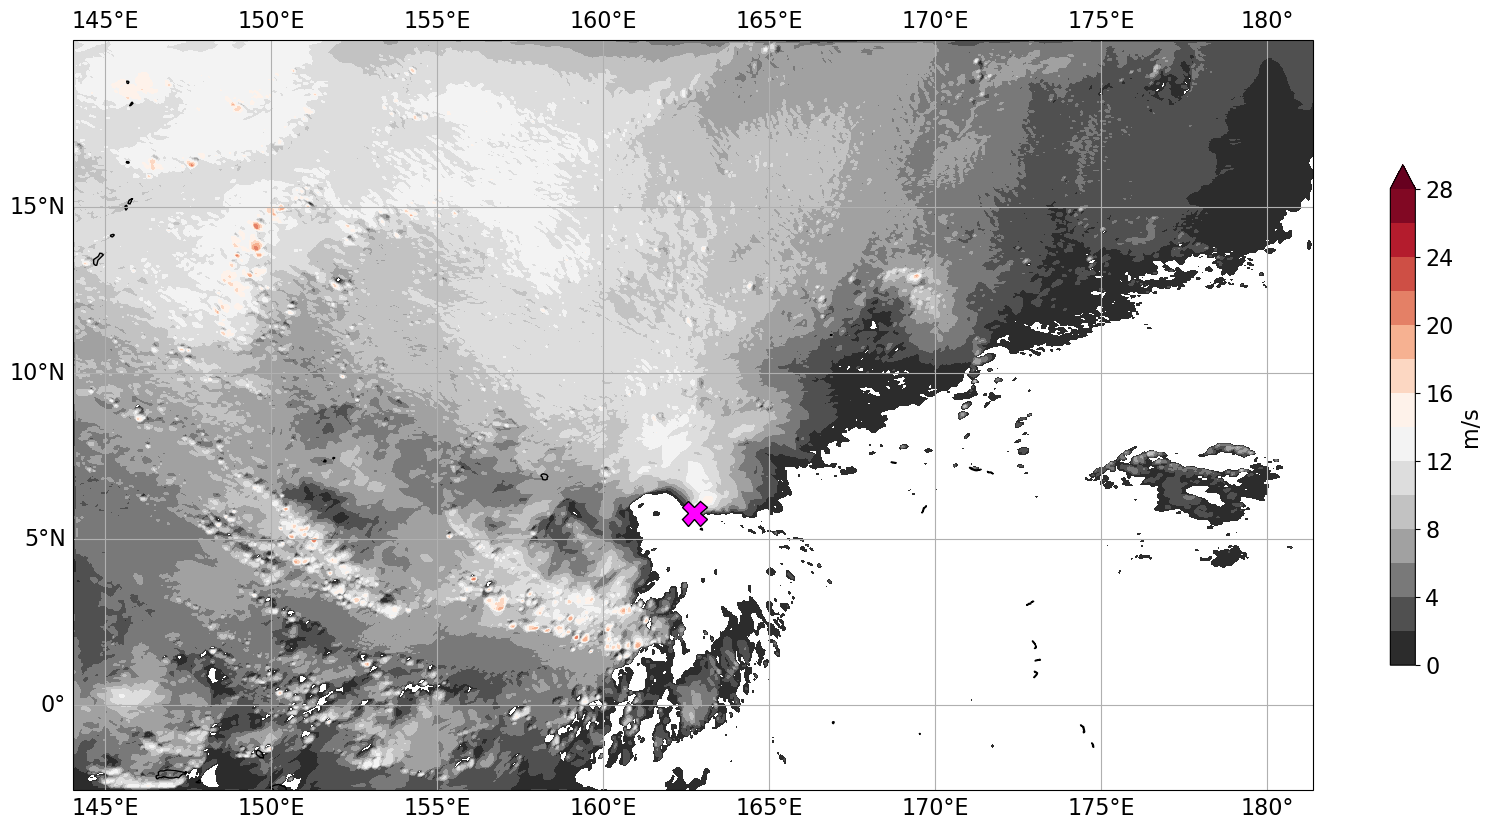

In [ ]:
# Plot tangential wind vtan

# select plotting area
plt_area=[lon1d[0], lon1d[-1], lat1d[0], lat1d[-1]] # W,E,S,N

tsel=26
# tsel=0
# for tsel in range(5,nt,6):
# for tsel in range(30,48,3):
# for tsel in range(26,32):

# hr_tag = str(np.char.zfill(str(t0), 3))
hr_tag = str(np.char.zfill(str(tsel), 3))
print(hr_tag)

iu = u[tsel,0,:,:]
iv = v[tsel,0,:,:]

rmax_mask=10
# lwacre_mask = mask_tc_track(track_file, rmax_mask, lwacre, lon, lat, t0, t1)

pltvar=np.copy(vtan)
pltvar=pltvar[tsel,0,:,:]
# pltvar=lwacre_mask[tsel,0,:,:]
# pltvar2=mslp[tsel,0,:,:]

unittag='m/s'
clevs = np.arange(0,30,2)

# create figure
fig = plt.figure(figsize=(20,10))
proj = cartopy.crs.PlateCarree(central_longitude=offset)
ax = fig.add_subplot(111,projection=proj)
title='V-tan (hr='+hr_tag+')'
# ax.set_title(title, fontsize=20)

# fill contour
# divnorm=colors.Normalize(vmin=clevs.min(), vcenter=0., vmax=clevs.max())

# Mask beyond a certain range of TC center
tc_locx=clon[tsel]# - 180
tc_locy=clat[tsel]
rad_plt=9
# plt_mask=[tc_locx-rad_plt, tc_locx+rad_plt, tc_locy-rad_plt, tc_locy+rad_plt] # W,E,S,N
# pltvar_ma = np.ma.masked_where(((lon <= plt_mask[0]) | (lon >= plt_mask[1]) | (lat <= plt_mask[2]) | (lat >= plt_mask[3])),
#                             pltvar, copy=True)

# im = ax.contourf(lon_offset_plt, lat, pltvar, clevs, cmap='RdGy_r', #alpha=0.9,
#                     extend='max', zorder=2, norm=divnorm)
# im = ax.contour(lon_offset_plt, lat, pltvar2, np.arange(960,1090,1))
im = ax.contourf(lon_offset_plt, lat, pltvar, clevs, cmap='RdGy_r', #alpha=0.9,
                    extend='max', zorder=1)#, norm=divnorm)

cbar = plt.colorbar(im, ax=ax, shrink=0.65)#, ticks=ticker.AutoLocator())
cbar.ax.set_ylabel(unittag)

# add map features
ax.add_feature(cartopy.feature.LAND,facecolor="lightgray") #land color
# ax.add_feature(cartopy.feature.OCEAN) #ocean color
ax.add_feature(cartopy.feature.COASTLINE)
ax.gridlines(draw_labels=True, xlocs=np.arange(140,190,5), ylocs=np.arange(-10,20,5),
            dms=True, x_inline=False, y_inline=False)

# Zoom into selected area (comment this out to plot entire available area)
# ax.set_extent(plt_mask)
plt.plot(tc_locx-180, tc_locy, marker="X", markersize=18, mec="black", mfc="magenta")#, markeredgewidth=0.1)

# Plot wind
skip=30
uplt = iu; vplt = iv
# plot_wind(ax, uplt, vplt, lon_offset_plt, lat, skip, length=7)

plt.show()
# plt.close()

026
ISTRAT:  0


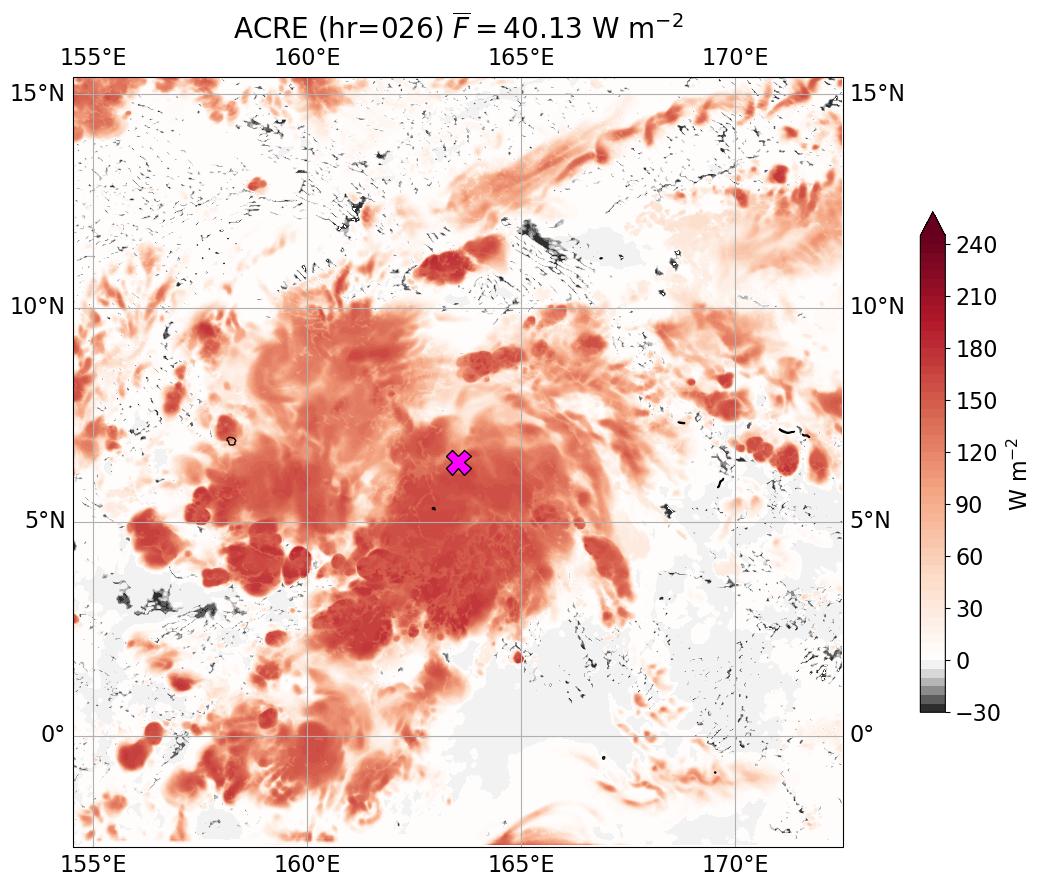

ISTRAT:  1


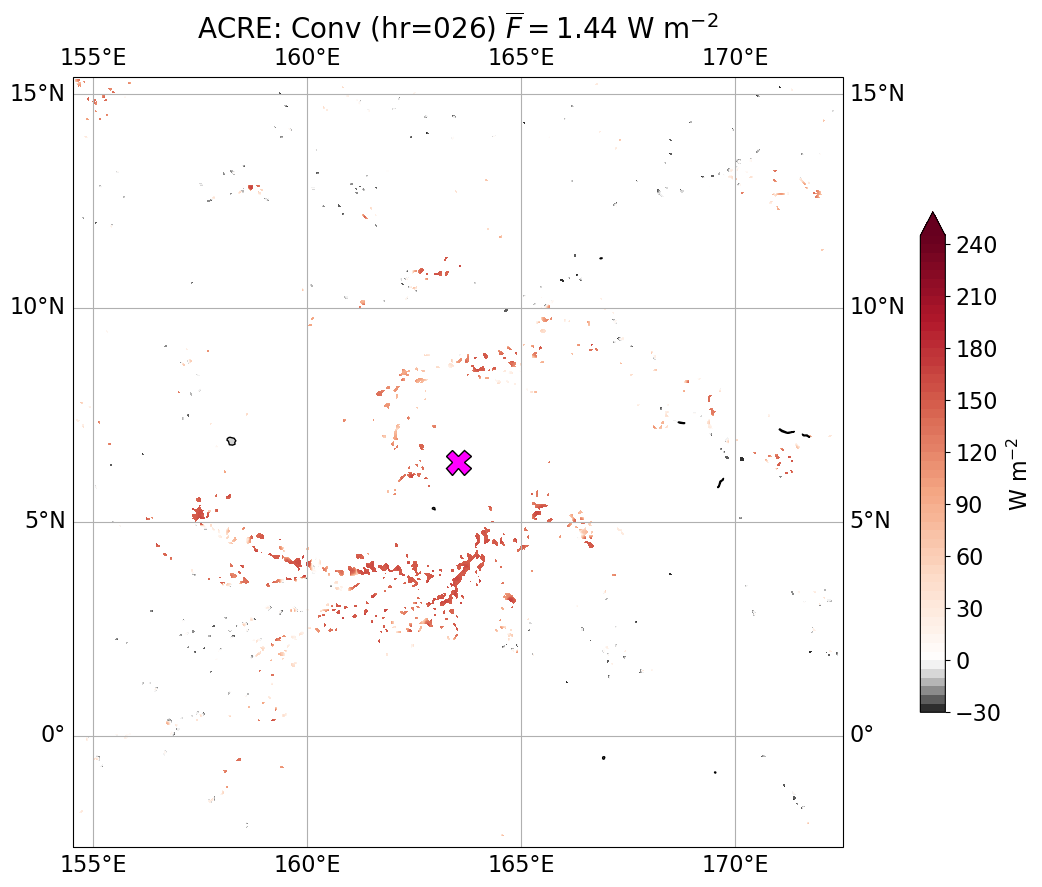

ISTRAT:  2


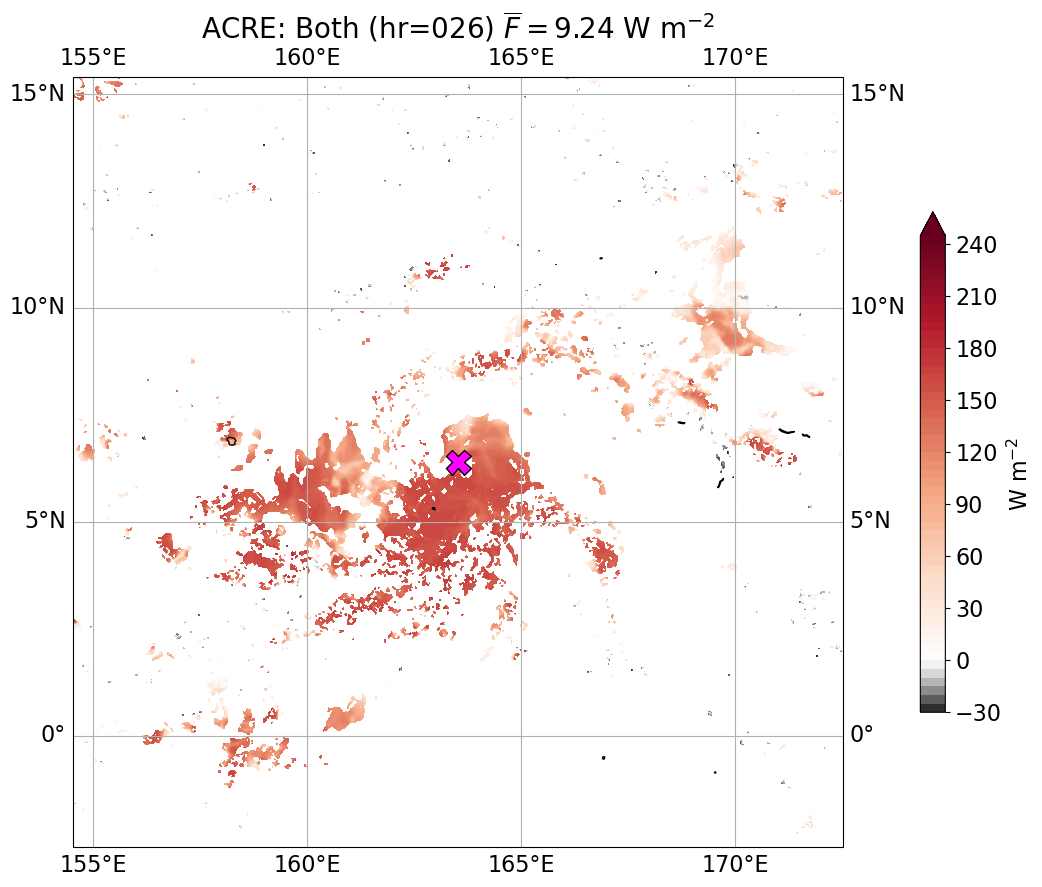

In [21]:
# LWACRE

# select plotting area
plt_area=[lon1d[0], lon1d[-1], lat1d[0], lat1d[-1]] # W,E,S,N

tsel=26
# tsel=0
# for tsel in range(5,nt,6):
# for tsel in range(30,48,3):
# for tsel in range(26,32):

# hr_tag = str(np.char.zfill(str(t0), 3))
hr_tag = str(np.char.zfill(str(tsel), 3))
print(hr_tag)

iu = u[tsel,0,:,:]
iv = v[tsel,0,:,:]

rmax_mask=10
# lwacre_mask = mask_tc_track(track_file, rmax_mask, lwacre, lon, lat, t0, t1)

for istrat in range(0,3):

    print('ISTRAT: ',istrat)

    vartag='ACRE'
    pltvar=np.copy(lwacre)
    pltvar=pltvar[tsel,0,:,:]
    # pltvar=lwacre_mask[tsel,0,:,:]
    # pltvar2=mslp[tsel,0,:,:]

    if istrat > 0:
        if istrat == 1:
            vartag+=': Conv'
            pltvar = np.ma.masked_where((strat[tsel,0,:,:] != istrat), pltvar, copy=True)
        elif istrat == 2:
            # vartag+=': Strat'
            # pltvar = np.ma.masked_where((strat[tsel,0,:,:] != istrat), pltvar, copy=True)
        # elif istrat == 3:
        #     vartag+=': Anvil'
        #     pltvar = np.ma.masked_where((strat[tsel,0,:,:] != istrat), pltvar, copy=True)
        # elif istrat == 4:
            vartag+=': Both'
            pltvar = np.ma.masked_where((strat[tsel,0,:,:] < 2), pltvar, copy=True)

    # pltvar = np.ma.masked_where((strat != istrat), pltvar, copy=True)

    unittag='W m$^{-2}$'
    clevs = np.arange(-30,250,5)

    # create figure
    fig = plt.figure(figsize=(20,10))
    proj = cartopy.crs.PlateCarree(central_longitude=offset)
    ax = fig.add_subplot(111,projection=proj)
    title=vartag+' (hr='+hr_tag+')'
    # ax.set_title(title, fontsize=20)

    # fill contour
    divnorm=colors.TwoSlopeNorm(vmin=clevs.min(), vcenter=0., vmax=clevs.max())

    # Mask beyond a certain range of TC center
    tc_locx=clon[tsel]# - 180
    tc_locy=clat[tsel]
    rad_plt=9
    plt_mask=[tc_locx-rad_plt, tc_locx+rad_plt, tc_locy-rad_plt, tc_locy+rad_plt] # W,E,S,N
    pltvar_ma = np.ma.masked_where(((lon <= plt_mask[0]) | (lon >= plt_mask[1]) | (lat <= plt_mask[2]) | (lat >= plt_mask[3])),
                                pltvar, copy=True)

    # im = ax.contourf(lon_offset_plt, lat, pltvar, clevs, cmap='RdGy_r', #alpha=0.9,
    #                     extend='max', zorder=2, norm=divnorm)
    # im = ax.contour(lon_offset_plt, lat, pltvar2, np.arange(960,1090,1))
    im = ax.contourf(lon_offset_plt, lat, pltvar_ma, clevs, cmap='RdGy_r', #alpha=0.9,
                        extend='max', zorder=1, norm=divnorm)

    cbar = plt.colorbar(im, ax=ax, shrink=0.65)#, ticks=ticker.AutoLocator())
    cbar.ax.set_ylabel(unittag)

    # add map features
    ax.add_feature(cartopy.feature.LAND,facecolor="lightgray") #land color
    # ax.add_feature(cartopy.feature.OCEAN) #ocean color
    ax.add_feature(cartopy.feature.COASTLINE)
    ax.gridlines(draw_labels=True, xlocs=np.arange(140,190,5), ylocs=np.arange(-10,20,5),
                dms=True, x_inline=False, y_inline=False)

    # Zoom into selected area (comment this out to plot entire available area)
    ax.set_extent(plt_mask)
    plt.plot(tc_locx-180, tc_locy, marker="X", markersize=18, mec="black", mfc="magenta")#, markeredgewidth=0.1)

    # Plot wind
    skip=30
    uplt = iu; vplt = iv
    # plot_wind(ax, uplt, vplt, lon_offset_plt, lat, skip, length=7)

    # Add mean value
    if istrat == 0:
        all_cells = np.ma.MaskedArray.count(pltvar_ma)
    # meanv=np.mean(pltvar)
    # meanv=np.mean(pltvar_ma)
    total=np.sum(pltvar_ma)
    meanv=total/all_cells
    meanv_str=str(np.round(meanv, decimals=2))
    # print('Mean = ', meanv_str)
    # xplt=tc_locx+3.5-180
    # yplt=tc_locy+3.5
    annot = '$\overline{F}='+meanv_str+'$ W m$^{-2}$'
    # ax.annotate(annot, xy=(2, 1), xytext=(xplt,yplt), size='x-large')
    title+=' '+annot
    ax.set_title(title, fontsize=20)

    plt.show()
    # plt.close()

026


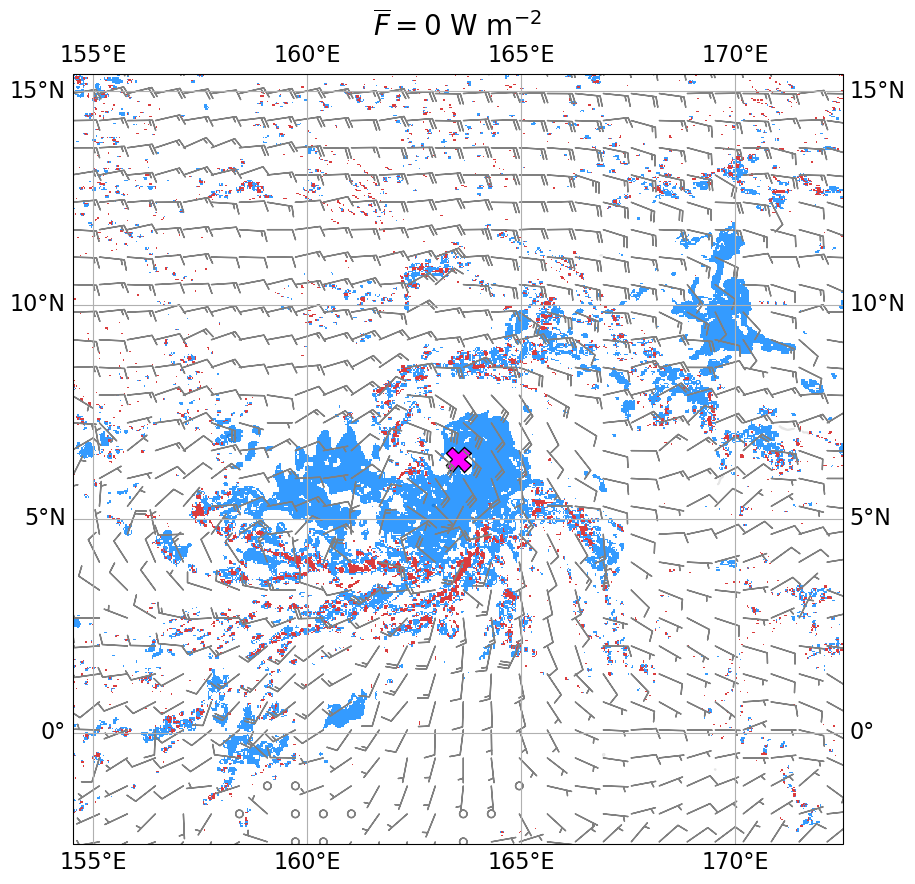

In [22]:
# STRAT CLASSIFICATION

# select plotting area
plt_area=[lon1d[0], lon1d[-1], lat1d[0], lat1d[-1]] # W,E,S,N

tsel=26
# tsel=0
# for tsel in range(5,nt,6):
# for tsel in range(30,48,3):
# for tsel in range(26,32):

# hr_tag = str(np.char.zfill(str(t0), 3))
hr_tag = str(np.char.zfill(str(tsel), 3))
print(hr_tag)

vartag='Classification'

iu = u[tsel,0,:,:]
iv = v[tsel,0,:,:]
pltvar=strat[tsel,0,:,:]
# pltvar=lwacre_mask[tsel,0,:,:]

# for nplot in range(2):

# create figure
fig = plt.figure(figsize=(20,10))
proj = cartopy.crs.PlateCarree(central_longitude=offset)
ax = fig.add_subplot(111,projection=proj)
ax.set_title(vartag+' (hr='+hr_tag+')', fontsize=20)

# fill contour
# for istrat in range(0,4):
#     pltvar=strat[tsel,0,:,:]
#     # istrat=pltvar.where
#     im = ax.fill(lon_offset_plt, lat, pltvar, clevs, facecolor='lightsalmon', alpha=0.9,
#                         zorder=2)

cMap = colors.ListedColormap(['white','tab:red','dodgerblue','dodgerblue'])#[200, 200, 200],[255, 0, 0],[0, 0, 255],[60, 179, 113]])
# if nplot == 0:
#     clevs = np.arange(0,5)
#     im = ax.contourf(lon_offset_plt, lat, pltvar, clevs, alpha=0.9,
#                         zorder=2, cmap=cMap)
# elif nplot == 1:
im = ax.pcolormesh(lon_offset_plt, lat, pltvar, alpha=0.9,
                    zorder=2, cmap=cMap)

# cbar = plt.colorbar(im, ax=ax, shrink=0.65, ticks=[0,1,2,3])#ticker.AutoLocator())

# add map features
ax.add_feature(cartopy.feature.LAND,facecolor="lightgray") #land color
# ax.add_feature(cartopy.feature.OCEAN) #ocean color
ax.add_feature(cartopy.feature.COASTLINE)
ax.gridlines(draw_labels=True, xlocs=np.arange(140,190,5), ylocs=np.arange(-10,20,5),
            dms=True, x_inline=False, y_inline=False)

# Zoom into selected area (comment this out to plot entire available area)
# ax.set_extent(plt_area)
tc_locx=clon[tsel]# - 180
tc_locy=clat[tsel]
rad_plt=9
plt_tcloc=[tc_locx-rad_plt, tc_locx+rad_plt, tc_locy-rad_plt, tc_locy+rad_plt] # W,E,S,N
ax.set_extent(plt_tcloc)
plt.plot(tc_locx-180, tc_locy, marker="X", markersize=18, mec="black", mfc="magenta")#, markeredgewidth=0.1)

# Plot wind
skip=21
length=6
uplt = iu; vplt = iv
plot_wind(ax, uplt, vplt, lon_offset_plt, lat, skip, length=length)

# Add mean value
meanv=np.mean(pltvar)
meanv_str=str(np.round(int(meanv)))
# print('Mean = ', meanv_str)
# xplt=tc_locx+3.5-180
# yplt=tc_locy+3.5
annot = '$\overline{F}='+meanv_str+'$ W m$^{-2}$'
# ax.annotate(annot, xy=(2, 1), xytext=(xplt,yplt), size='x-large')
ax.set_title(annot, fontsize=20)

plt.show()
# plt.close()

026
ISTRAT:  0


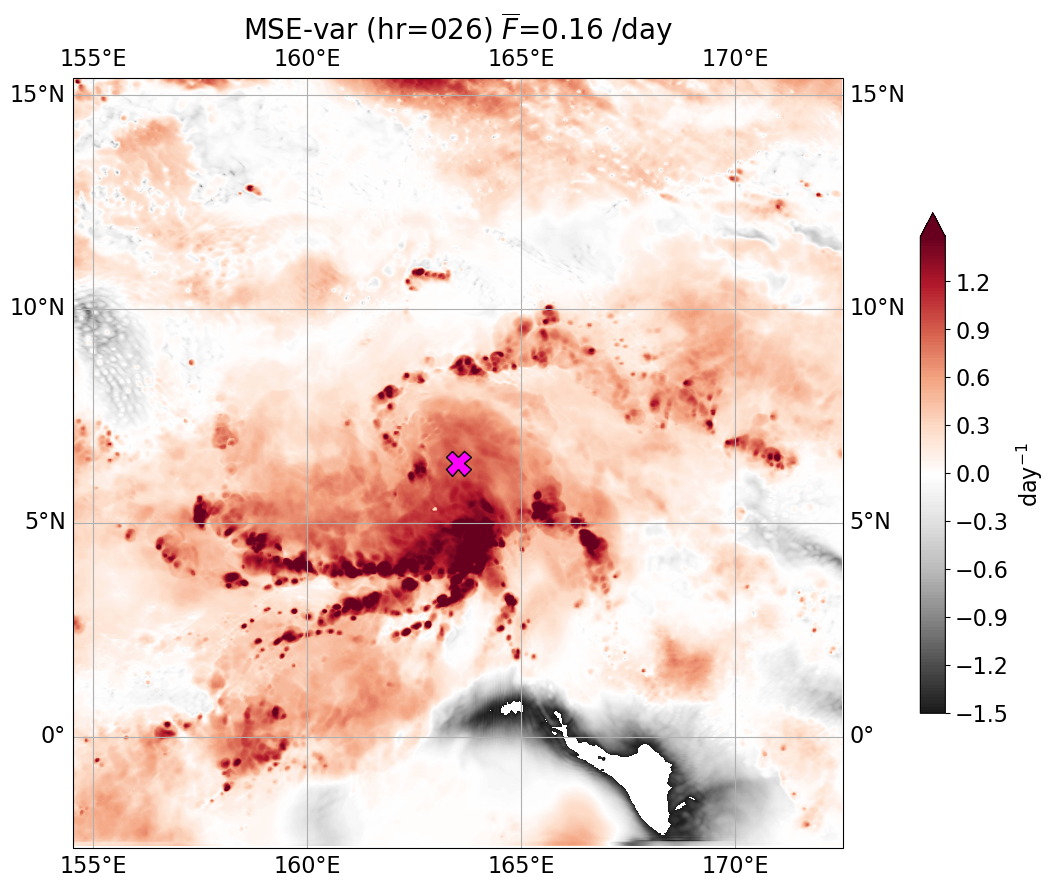

ISTRAT:  1


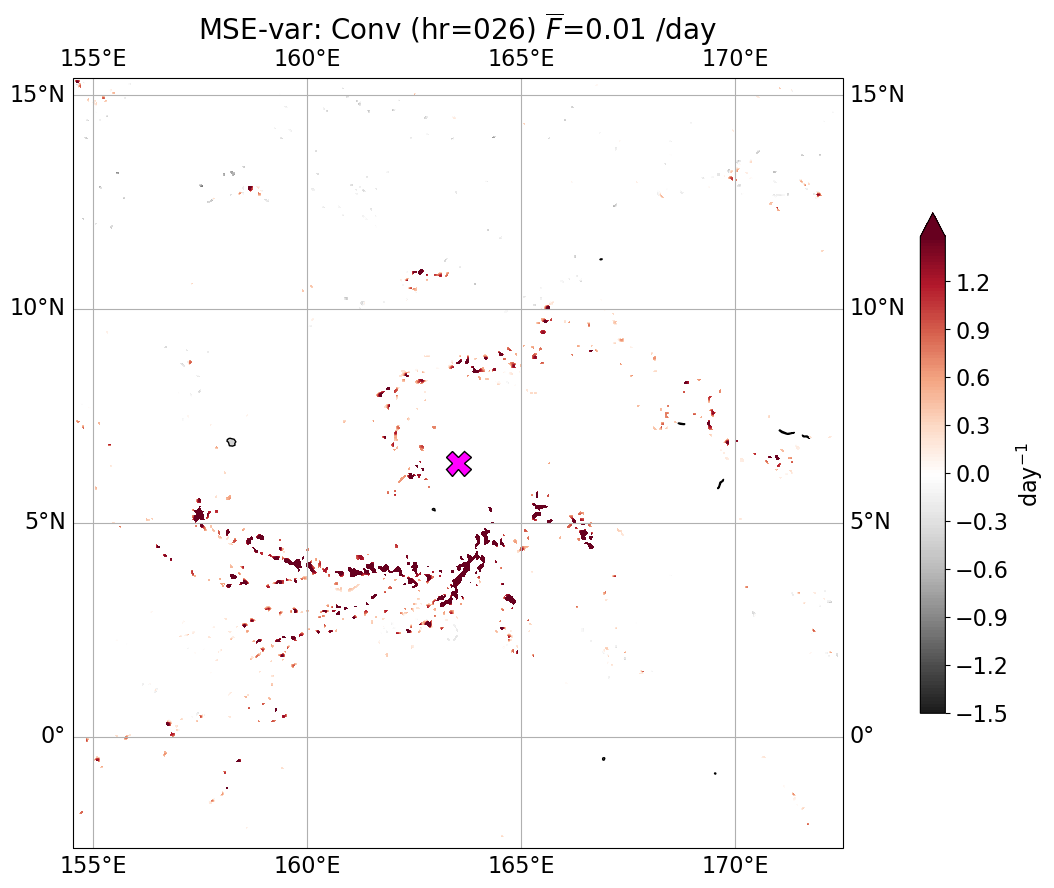

ISTRAT:  2


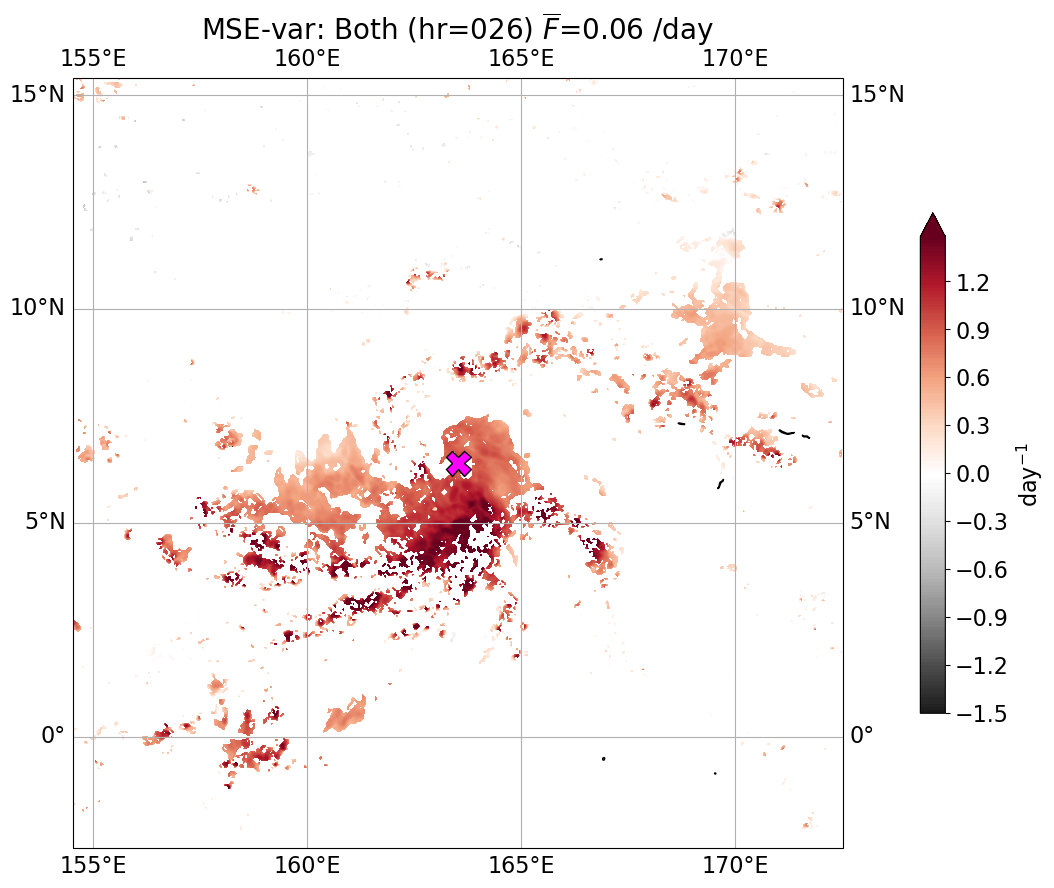

In [26]:
# LWACRE

# select plotting area
plt_area=[lon1d[0], lon1d[-1], lat1d[0], lat1d[-1]] # W,E,S,N

tsel=26
# tsel=0
# for tsel in range(5,nt,6):
# for tsel in range(30,48,3):
# for tsel in range(26,32):

# hr_tag = str(np.char.zfill(str(t0), 3))
hr_tag = str(np.char.zfill(str(tsel), 3))
print(hr_tag)

iu = u[tsel,0,:,:]
iv = v[tsel,0,:,:]

rmax_mask=10
# lwacre_mask = mask_tc_track(track_file, rmax_mask, lwacre, lon, lat, t0, t1)

for istrat in range(0,3):
# for istrat in range(0,1):

    print('ISTRAT: ',istrat)

    vartag='MSE-var'
    # pltvar=np.copy(lwmse)
    pltvar=np.copy(lwmsec)
    pltvar=pltvar[tsel,:,:]

    if istrat > 0:
        if istrat == 1:
            vartag+=': Conv'
            pltvar = np.ma.masked_where((strat[tsel,0,:,:] != istrat), pltvar, copy=True)
        elif istrat == 2:
            # vartag+=': Strat'
            # pltvar = np.ma.masked_where((strat[tsel,0,:,:] != istrat), pltvar, copy=True)
        # elif istrat == 3:
        #     vartag+=': Anvil'
        #     pltvar = np.ma.masked_where((strat[tsel,0,:,:] != istrat), pltvar, copy=True)
        # elif istrat == 4:
            vartag+=': Both'
            pltvar = np.ma.masked_where((strat[tsel,0,:,:] < 2), pltvar, copy=True)

    # pltvar = np.ma.masked_where((strat != istrat), pltvar, copy=True)

    scale=1
    # unittag='10$^{-'+str(int(scale))+'}$ W m$^{-2}$'
    unittag='day$^{-1}$'
    # clevs = np.arange(-30,250,5)

    # create figure
    fig = plt.figure(figsize=(20,10))
    proj = cartopy.crs.PlateCarree(central_longitude=offset)
    ax = fig.add_subplot(111,projection=proj)
    title=vartag+' (hr='+hr_tag+')'
    # ax.set_title(title, fontsize=20)

    # fill contour
    pltvar*=(10**scale)
    clevs = np.arange(-1.5,1.5,0.02)
    # divnorm=colors.TwoSlopeNorm(vmin=clevs.min(), vcenter=0., vmax=clevs.max())

    # Mask beyond a certain range of TC center
    tc_locx=clon[tsel]# - 180
    tc_locy=clat[tsel]
    rad_plt=9
    plt_mask=[tc_locx-rad_plt, tc_locx+rad_plt, tc_locy-rad_plt, tc_locy+rad_plt] # W,E,S,N
    pltvar_ma = np.ma.masked_where(((lon <= plt_mask[0]) | (lon >= plt_mask[1]) | (lat <= plt_mask[2]) | (lat >= plt_mask[3])),
                                pltvar, copy=True)

    im = ax.contourf(lon_offset_plt, lat, pltvar_ma, clevs, cmap='RdGy_r', #alpha=0.9,
                        extend='max', zorder=2)#, norm=divnorm)

    cbar = plt.colorbar(im, ax=ax, shrink=0.65)#, ticks=ticker.AutoLocator())
    cbar.ax.set_ylabel(unittag)

    # add map features
    ax.add_feature(cartopy.feature.LAND,facecolor="lightgray") #land color
    # ax.add_feature(cartopy.feature.OCEAN) #ocean color
    ax.add_feature(cartopy.feature.COASTLINE)
    ax.gridlines(draw_labels=True, xlocs=np.arange(140,190,5), ylocs=np.arange(-10,20,5),
                dms=True, x_inline=False, y_inline=False)

    # Zoom into selected area (comment this out to plot entire available area)
    ax.set_extent(plt_mask)
    plt.plot(tc_locx-180, tc_locy, marker="X", markersize=18, mec="black", mfc="magenta")#, markeredgewidth=0.1)

    # Plot wind
    skip=30
    uplt = iu; vplt = iv
    # plot_wind(ax, uplt, vplt, lon_offset_plt, lat, skip, length=7)

    # Add mean value
    if istrat == 0:
        all_cells = np.ma.MaskedArray.count(pltvar_ma)
    # meanv=np.mean(pltvar)
    # meanv=np.mean(pltvar_ma)
    total=np.sum(pltvar_ma)
    meanv=total/all_cells
    meanv_str=str(np.round(meanv, decimals=2))
    # print('Mean = ', meanv_str)
    # xplt=tc_locx+3.5-180
    # yplt=tc_locy+3.5
    # annot = '$\overline{F}='+meanv_str+'$'+r'$\times10^{-'+str(int(scale))+'}$ W m$^{-2}$'
    annot = '$\overline{F}$='+meanv_str+' /day'
    # ax.annotate(annot, xy=(2, 1), xytext=(xplt,yplt), size='x-large')
    title+=' '+annot
    ax.set_title(title, fontsize=20)

    plt.show()
    # plt.close()